In [5]:
import os
import wfdb
import numpy as np
import math
import matplotlib.pyplot as plt
path = r"C:\Users\paul.ilioaica\Downloads\ptb-diagnostic-ecg-database-1.0.0\ptb-diagnostic-ecg-database-1.0.0"

## Loading pacients data

In [2]:
pacients_dir = [x.strip("\n") for x in open(os.path.join(path,"RECORDS"), "r").readlines()]
pacients = []
for pacient in pacients_dir:
    current_path = os.path.join(path, pacient)
    record = wfdb.rdrecord(current_path)
    try:
        if record.__dict__["comments"][4].split(":")[1].strip() != "n/a":
            pacient = {"sex" : record.__dict__["comments"][1].split(":")[1].strip(),
                       "age" : int(record.__dict__["comments"][0].split(":")[1]),
                       "diagnostic" : record.__dict__["comments"][4].split(":")[1].strip(),
                        "signals" : record.__dict__["p_signal"]
                        }
            pacients.append(pacient)
    except:
        pass
unique_problems = list(set([pacient["diagnostic"] for pacient in pacients]))


## Generating i-wave histogram for each disease

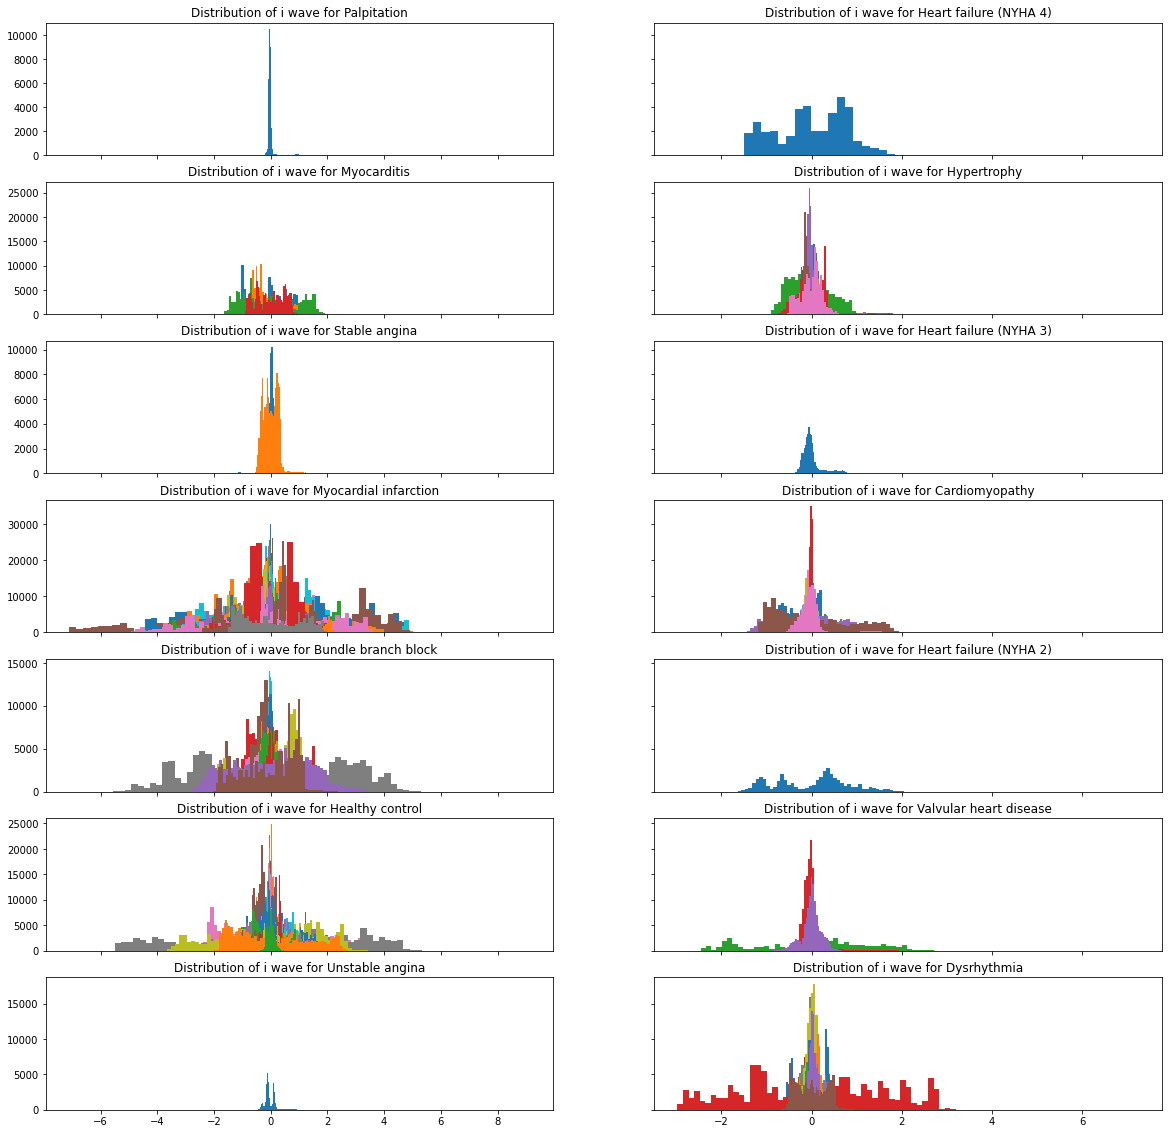

In [7]:

fig, ax = plt.subplots(7,2,sharex='col', sharey='row', figsize=(20,20))
i = 0
for figx in ax:
    for figy in figx:
        [figy.hist(pacient['signals'][:,0], bins=50) for pacient in pacients if pacient["diagnostic"] == unique_problems[i]]
        figy.set_title(f"Distribution of i wave for {unique_problems[i]}")
        i += 1

### Creating a dataset with the pacient records and i-wave features

In [ ]:
from scipy.stats import kurtosis, skew
dataset = []
sex_dict = {"male":0,
           "female":1}
disease_dict = {problem:i for i, problem in enumerate(unique_problems)}
for pacient in pacients:
    std = pacient["signals"][:,0].std()
    krt = kurtosis(pacient["signals"][:,0])
    skw = skew(pacient["signals"][:,0])
    rms = math.sqrt(sum(pacient["signals"][:,0]**2)/len(pacient["signals"][:,0]))
    energy = np.sum(np.abs(pacient["signals"][:,0]**2)/ len(pacient["signals"][:,0]))
    pacient_entry = [pacient["age"], sex_dict[pacient['sex']], std, krt, skw, rms, energy, disease_dict[pacient['diagnostic']]]
    dataset.append(pacient_entry)
dataset = np.array(dataset).T

### Computing covariance matrix

In [ ]:
cov_matrix = np.copy(dataset.T)
cov_matrix -= cov_matrix.mean(axis=0)
N = cov_matrix.shape[0] 
cov_matrix = np.dot(cov_matrix.T, cov_matrix.conj()) / float(N - 1)

In [ ]:
import seaborn as sn
sn.set(rc={'figure.figsize':(10.7,10.27)})
sn.heatmap(cov_matrix, annot=True, fmt='g')

### PCA on covariance matrix

In [ ]:
eig_val, eig_vec = np.linalg.eig(cov_matrix)

In [ ]:
retain_value = sum(eig_val[:-4])/(sum(eig_val))
print(f"After selecting top 4 eigen values, we are keeping {100* retain_value}% of the information")

In [ ]:
eig_vec_filtered = eig_vec[:, :4]

In [ ]:
new_dataset = eig_vec_filtered.T.dot(dataset)

In [ ]:
print(f"Reducing the dataset size to 4 dimesions: {new_dataset.shape}")

### K-Means Clusterization

#### Loading test data

In [ ]:
test_dir = [x.strip("\n") for x in open(os.path.join(path,"CONTROLS"), "r").readlines()]
test_pacients = []
test_dataset = []
for pacient in test_dir:
    current_path = os.path.join(path, pacient)
    record = wfdb.rdrecord(current_path)
    try:
        if record.__dict__["comments"][4].split(":")[1].strip() != "n/a":
            pacient = {"sex" : record.__dict__["comments"][1].split(":")[1].strip(),
                       "age" : int(record.__dict__["comments"][0].split(":")[1]),
                       "diagnostic" : record.__dict__["comments"][4].split(":")[1].strip(),
                        "signals" : record.__dict__["p_signal"]
                        }
            test_pacients.append(pacient)
    except:
        pass
test_dataset = []
for pacient in test_pacients:
    std = pacient["signals"][:,0].std()
    krt = kurtosis(pacient["signals"][:,0])
    skw = skew(pacient["signals"][:,0])
    rms = math.sqrt(sum(pacient["signals"][:,0]**2)/len(pacient["signals"][:,0]))
    energy = np.sum(np.abs(pacient["signals"][:,0]**2)/ len(pacient["signals"][:,0]))
    pacient_entry = [pacient["age"], sex_dict[pacient['sex']], std, krt, skw, rms, energy, disease_dict[pacient['diagnostic']]]
    test_dataset.append(pacient_entry)


## Implementing K Means

In [ ]:
def kmeans(dataset, k = 3):
    clusters = [[] for i in range(k)]
    clusters_coord = [np.random.rand(4) for i in range(k)]
    old_clusters = [0,0,0,0]
    while all([not np.array_equal(x, y) for x,y in zip(old_clusters, clusters_coord)]):
        old_clusters  = [x for x in clusters_coord]
        for datapoint in dataset:
            min_cluster = None
            min_distance = 100000000000
            for i, cluster in enumerate(clusters_coord):
                dist = np.linalg.norm(datapoint-cluster)
                if dist < min_distance:
                    min_distance = dist
                    min_cluster = i
            clusters[min_cluster].append(datapoint)
        print(clusters)
        time.sleep(2000)
        for i, group in enumerate(clusters):
            cluster_coord = np.mean(np.array(group))
            clusters_coord[i] = cluster_coord
    return clusters_coord


In [ ]:
kmeans(new_dataset.T)